In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import random
from scipy.interpolate import splrep

## Exploratory Data Analysis of subset FD001
Dataset FD001 contains the sensordata from run-to-failure experiments, simulated using the CMAPSS software. During the entire experiment, only one possible fault could occur and each timecycle happened under the same conditions.

### Reading in and transforming the data
I use the pandas library to read the data from the csv into a DataFrame. The sensordata gets min-max normalized.
Since the data is sensordata from "run-to-failure" experiments, it's safe to assume the last datapoint of each unit contains the data from the last cycle the unit was active. We can therefore create a RUL-column, counting down to this last cycle.

In [2]:
filepath = '../Data/CMAPSSData/train_FD001.txt'
index_columns = ['unit_nr', 'time_cycles']
setting_columns = ['setting_1', 'setting_2', 'setting_3']
sensor_columns = ['s_{}'.format(i) for i in range(1,22)]
columns = index_columns + setting_columns + sensor_columns
df = pd.read_csv(filepath, sep='\s+', header=None, names=columns)

scaler = MinMaxScaler()
df[sensor_columns] = pd.DataFrame(scaler.fit_transform(df[sensor_columns]))

df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,1,2,0.0019,-0.0003,100.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,1,3,-0.0043,0.0003,100.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,1,4,0.0007,0.0000,100.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,1,5,-0.0019,-0.0002,100.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502


In [3]:
max_cycle = df.groupby(by='unit_nr')['time_cycles'].max()
result_frame = df.merge(max_cycle.to_frame(name='max'), left_on='unit_nr', right_index=True)
df['RUL'] = result_frame['max'] - result_frame['time_cycles']
df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.0019,-0.0003,100.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,-0.0043,0.0003,100.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.0007,0.0000,100.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,-0.0019,-0.0002,100.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


### Investigation of the data

As a start,a standard 'describe()' operation will be called upon the data gathered from the sensors. This will give a first glance at the statistical properties of the data.

In [4]:
sensor_data = df[sensor_columns]
sensor_data.describe().T

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
s_2,20631.0,0.443052,0.150618,0.0,0.335843,0.430723,0.539157,1.0
s_3,20631.0,0.424746,0.133664,0.0,0.331807,0.415522,0.508829,1.0
s_4,20631.0,0.450435,0.151935,0.0,0.339467,0.435348,0.545324,1.0
s_5,20631.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
s_6,20631.0,0.980321,0.138898,0.0,1.000000,1.000000,1.000000,1.0
s_7,20631.0,0.566459,0.142527,0.0,0.476651,0.578100,0.669887,1.0
s_8,20631.0,0.297957,0.107554,0.0,0.227273,0.287879,0.363636,1.0
s_9,20631.0,0.195248,0.099089,0.0,0.140761,0.174684,0.213991,1.0
s_10,20631.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


Looking at the table above, it can be noticed that sensors 1, 5, 10, 16, 18, and 19 all have a standard deviation of 0. This means there is no fluctuation in the values these sensors send during the entire experiment. Therefore, it can be safely assumed these sensors don't contain any useful information, pertaining the predictions of remaining useful life. In the rest of this notebook, they will be dropped.

In [5]:
sensor_columns = [sensor for sensor in sensor_columns if sensor not in ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']]

A correlation matrix can be used to see if some sensors contain a lot of information about the remaining useful life and if some sensors contain duplicate information.

<AxesSubplot:>

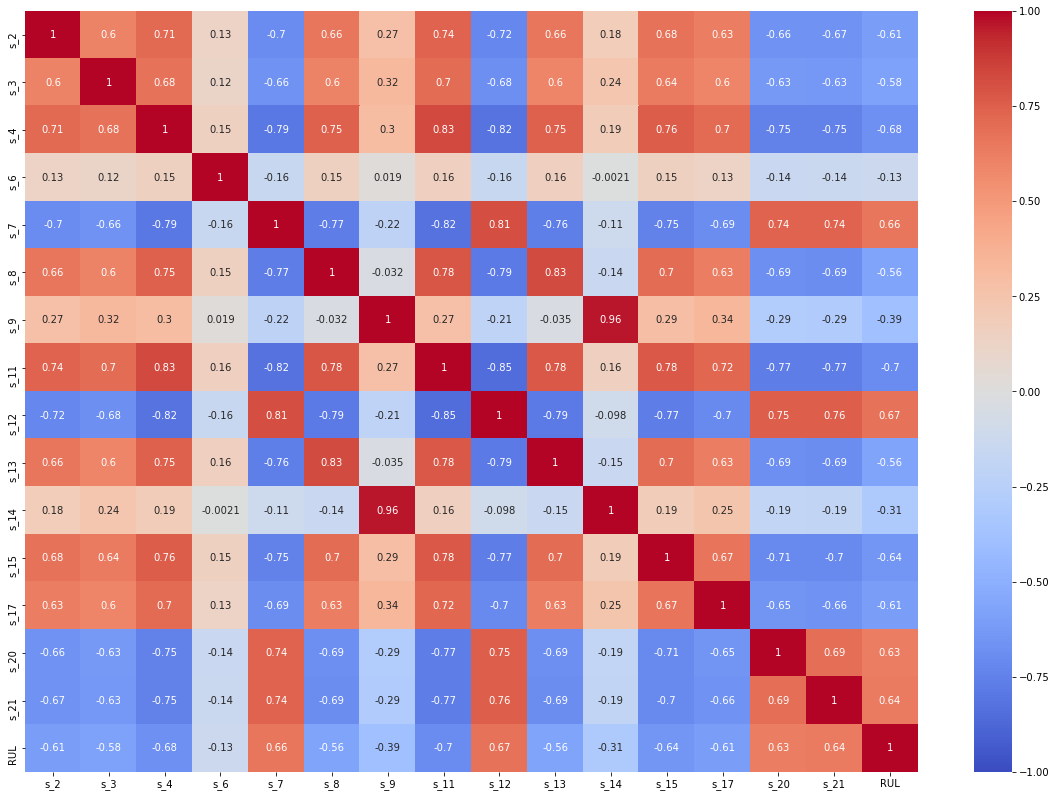

In [6]:
corr_matrix = df[sensor_columns+['RUL']].corr()
plt.figure(figsize=(20,14))
sns.heatmap(data=corr_matrix, annot=True, vmin=-1, vmax=1, center=0, cmap='coolwarm')

Let's take a random sample from all different unit numbers and plot the sensor-data for the chosen engine. Since each engine is from the same fleet and should, according to NASA, be considered of the same type, this should give an idea about how the sensors evolve during the experiment. However, it should be stated that each engine unit will be slightly different.

Chosen engine: 49


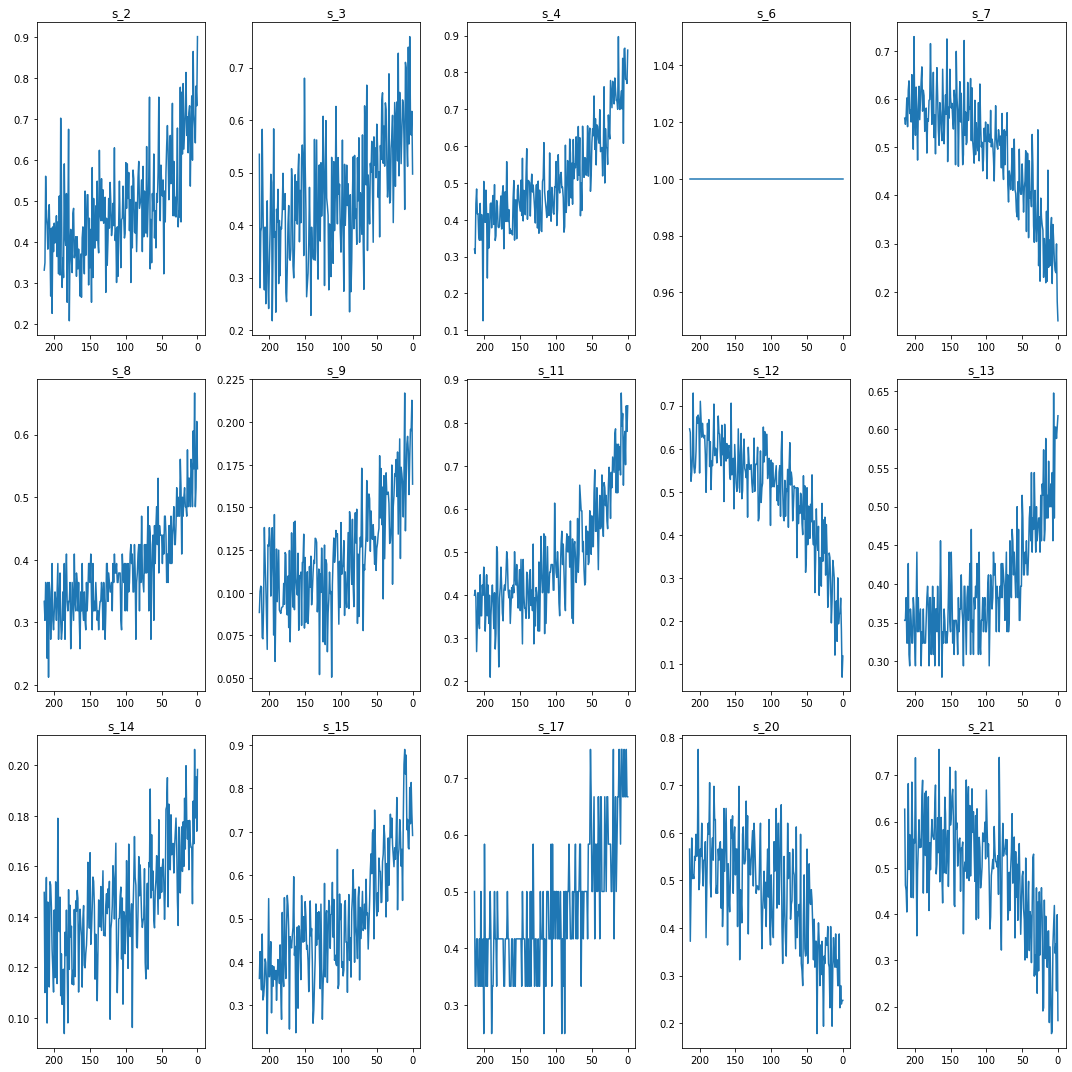

In [7]:
random_sample = random.choice(df['unit_nr'].unique())
print("Chosen engine: {}".format(random_sample))
data = df[df['unit_nr']==random_sample]

cols = math.ceil(len(sensor_columns)/3)
rows = math.ceil(len(sensor_columns)/cols)
fig, axes = plt.subplots(rows, cols)
fig.set_figheight(15)
fig.set_figwidth(15)
for row in range(0, rows):
    for col in range(0, cols):
        sensor = sensor_columns[cols*row+col]
        axes[row][col].plot(data['RUL'], data[sensor])
        axes[row][col].invert_xaxis()
        axes[row][col].title.set_text(sensor)
plt.tight_layout()

First, sensor 6 seems to be a constant value as well, except for some outliers. Sensor 6 does not contain any useful information about the remaining useful life.  
More importantly, these graphs show an interesting feature of the data. Most graphs start off as quasi-constant, but at some point in time start to rise or fall sharply. This rise and fall happens around 100 cycles before the engine fails. This can be explained as follows: each engine starts with some minor defects, but are not yet damaged. At some unknown point during the experiment a fault gets introduced. After this, engines might not immediately start showing strange sensorreadings. However, once they do, it takes about 100 cycles before the engine completely fails. It's important that this does not say anything about when the fault was introduced, but just that when damage starts to happen, it suddenly grows exponentially.

However, our RUL is a constant downwards number. So of course, the quasi-constant part of the sensor-readings will not correlate with the RUL. A solution would be to clip the remaining useful life to some value around 100 and state that when the RUL is this number, the engine functions properly. When the RUL dips under that number, than the actual RUL-prediction can happen. So now only one problem remains: what is this upper limit-number?  
Other literature clips at 120, so let's do the same.

In [8]:
sensor_columns.remove('s_6')
df['RUL'] = df['RUL'].clip(upper=125)

<AxesSubplot:>

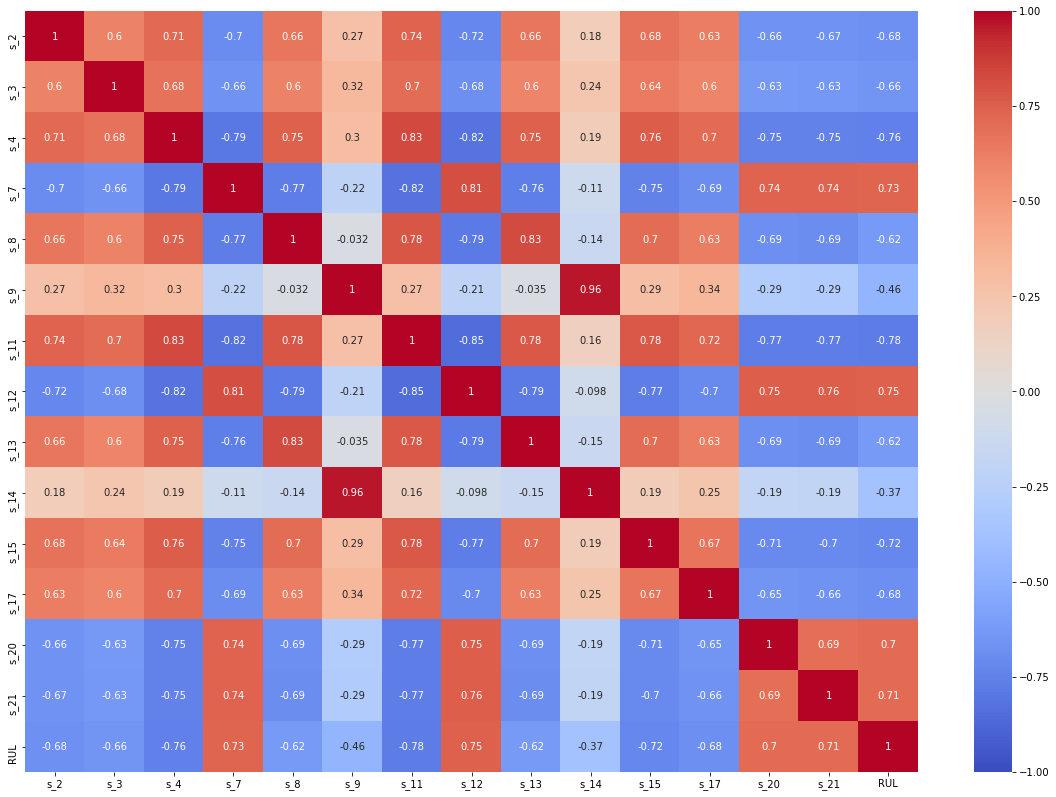

In [9]:
corr_matrix = df[sensor_columns+['RUL']].corr()
plt.figure(figsize=(20,14))
sns.heatmap(data=corr_matrix, annot=True, vmin=-1, vmax=1, center=0, cmap='coolwarm')